In [62]:
# Importing all libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
import string
import re
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


In [2]:
# Opening our dataset through pandas

df_train = pd.read_csv("data/drugsComTrain_raw.tsv", delimiter='\t', encoding = 'utf-8')
df_test = pd.read_csv("data/drugsComTest_raw.tsv", delimiter='\t', encoding = 'utf-8')
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [5]:
# renaming column Unnamed: 0 as ID
df = df.rename(columns = {'Unnamed: 0': 'ID'})

# dropping Nan's for column condition
df.dropna(subset = ['condition'], inplace=True)
df.head()

,ID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [9]:
# Classifying Target variable as 2 classes: positive_rating (6-10) & negative_rating(0-5)
df['rating'] = df['rating'].replace({1.0:0, 2.0:0, 3.0:0, 4.0:0, 5.0:0, 6.0:1, 7.0:1, 8.0:1, 9.0:1, 10.0:1})

## Final Model using TensorFlow and Keras:

Choosing sample dataset of 30K to start with TensorFlow, and trying Random Forest, Naive Bayes and XGBoost for better results.


In [11]:
# Downsampling method
pos_df = df[df['rating']==1]
neg_df = df[df['rating']==0]


In [63]:
sample_size = 30000
ds_pos_df = pos_df.sample(n=sample_size, random_state=42)
ds_neg_df = neg_df.sample(n=sample_size, random_state=42)

# merging 2 datasets
balanced2_df = pd.concat([ds_pos_df, ds_neg_df])
balanced2_df['rating'].value_counts()

rating
1.0    30000
0.0    30000
Name: count, dtype: int64

In [64]:
# Train test split
X = balanced2_df['review']
y= balanced2_df['rating']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

((42000,), (18000,), (42000,), (18000,))

In [17]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data, y = 0):
        return self

    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.process_doc)
        return normalized_corpus

    def process_doc(self, doc):
        lemm = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None
        normalized_doc = [token.lower() for token in word_tokenize(doc) if ((token.isalpha()) & (token not in stop_words))]
        tagged_tokens = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(normalized_doc)))
        normalized_doc = [lemm.lemmatize(token, pos) for token, pos in tagged_tokens if pos is not None]
        return " ".join(normalized_doc)

In [65]:
# preprocessing
lemm = TextPreprocessor()
X_train3_trans = lemm.fit_transform(X_train3)
X_test3_trans = lemm.transform(X_test3)

In [66]:
# Vectorizing
tfidf = TfidfVectorizer()
X_train3_vec = tfidf.fit_transform(X_train3_trans)
X_test3_vec = tfidf.transform(X_test3_trans)

In [67]:
# Assuming X_train3_vec is a SparseTensor object
X_train3_dense = csr_matrix.toarray(X_train3_vec)
X_test3_dense = csr_matrix.toarray(X_test3_vec)

In [68]:
X_train3_dense.shape

(42000, 23328)

In [72]:
n_features = (23328, )
reg = l2(3e-3) 
tensor_med_model = Sequential()
tensor_med_model.add(Dense(32, activation='relu', kernel_regularizer = reg, input_shape = (n_features)))
tensor_med_model.add(Dense(16, activation='relu', kernel_regularizer = reg))
tensor_med_model.add(Dense(1, activation = 'sigmoid'))

In [74]:
# Compile and train your model
tensor_med_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


In [75]:
trainCallback = EarlyStopping(monitor='loss', min_delta = 1e-6, patience = 5)

history_med = tensor_med_model.fit(X_train3_dense, y_train3, epochs=10, batch_size= 50, validation_split=0.2, callbacks=[trainCallback])

Epoch 1/10
672/672 [==============================] - 48s 69ms/step - loss: 0.6417 - accuracy: 0.7553 - val_loss: 0.6056 - val_accuracy: 0.7743
Epoch 2/10
672/672 [==============================] - 42s 62ms/step - loss: 0.5921 - accuracy: 0.7813 - val_loss: 0.5916 - val_accuracy: 0.7814
Epoch 3/10
672/672 [==============================] - 42s 63ms/step - loss: 0.5800 - accuracy: 0.7829 - val_loss: 0.5894 - val_accuracy: 0.7752
Epoch 4/10
672/672 [==============================] - 42s 63ms/step - loss: 0.5683 - accuracy: 0.7850 - val_loss: 0.5770 - val_accuracy: 0.7795
Epoch 5/10
672/672 [==============================] - 41s 61ms/step - loss: 0.5598 - accuracy: 0.7905 - val_loss: 0.5729 - val_accuracy: 0.7782
Epoch 6/10
672/672 [==============================] - 41s 61ms/step - loss: 0.5506 - accuracy: 0.7932 - val_loss: 0.5700 - val_accuracy: 0.7796
Epoch 7/10
672/672 [==============================] - 41s 60ms/step - loss: 0.5418 - accuracy: 0.7962 - val_loss: 0.5735 - val_accuracy:

In [76]:
y_proba = tensor_med_model.predict(X_test3_dense) 
y_proba[0:5]

563/563 [==============================] - 38s 67ms/step


array([[0.31440365],
       [0.9833403 ],
       [0.7728145 ],
       [0.52768534],
       [0.10425448]], dtype=float32)

In [77]:
# returns loss + results of metrics used
tensor_med_model.evaluate(X_test3_dense, y_test3, verbose=0)

[0.5390809774398804, 0.785444438457489]

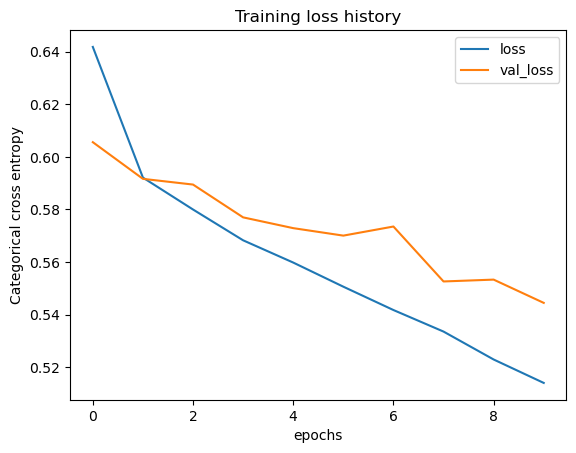

In [78]:
train_med_history = pd.DataFrame(history_med.history)
train_med_history.index.name = 'epochs'

col_list = ['loss',  'val_loss']
train_med_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')

plt.savefig('training_loss_history.png', dpi=300)

plt.show()

<Figure size 500x400 with 0 Axes>

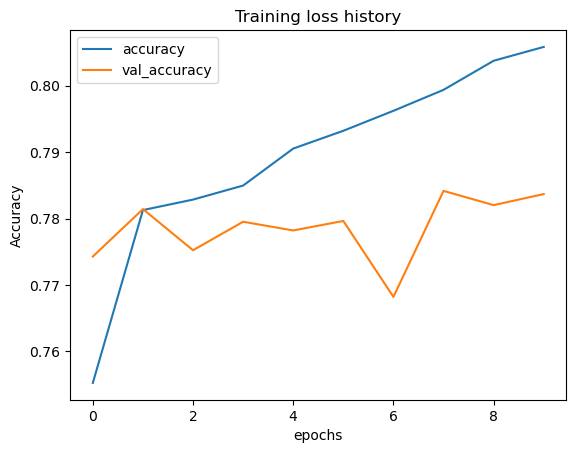

In [79]:
col_list = ['accuracy', 'val_accuracy']
plt.figure(figsize=(5,4))
train_med_history[col_list].plot()

plt.ylabel('Accuracy')
plt.title('Training loss history')

plt.savefig('training_accuracy_history.png', dpi=300)

plt.show()

In [80]:
predicted = np.argmax(y_proba, axis=-1)
predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

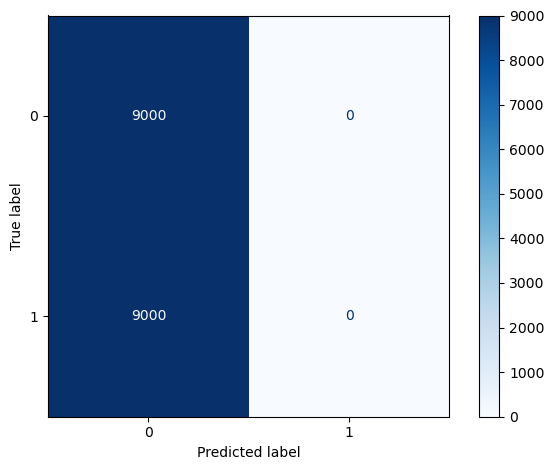

In [81]:
cm_digits = confusion_matrix(y_test3, predicted)
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_digits)

disp2.plot(cmap=plt.cm.Blues)
plt.tight_layout()
# Saved the figure
disp2.figure_.savefig('confusion_matrix_Tensor.png', dpi=300)

plt.show()